# GBT Lower Bounding Method

---
## 1. Setup


### 1.1 Packages




In [1]:
#import sys
#sys.path.append("/Users/zhaoziyue/opt/anaconda3/lib/python3.8/site-packages")
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor
import time
from pandas import DataFrame
import scipy.stats

from copy import deepcopy
import matplotlib.pyplot as plt

from prepareziyue import *
from BB import *
from gurobipy import *
from Node import *
import math

### 1.2 Data
We read the data into python using pandas.

In [2]:
# read the data 
df = pd.read_csv('concrete.csv')
df=df.drop(df.columns[0], axis=1)
X_variable=df.iloc[:,:-1]
Y_variable=df.iloc[:,-1]

labels=np.array(Y_variable)
feature_list = list(X_variable.columns)
features = np.array(X_variable)

We use random forests regression.

In [3]:
#random forests regression (n_estimators=20)
flag=1 
rf=get_rf_gb_(features,labels,20,flag)
trees=get_input(rf,flag)

## 1. Lower bounding method——Random forests

We have the domain lb<=x<=ub. And then we could use the `get_GBT_lower_bound` function to get the GBT lower bound with different tree partition subset size.

In [32]:
# Define the domain
lb={}
ub={}
for i in total_split_variable(trees):
    lb[i]=-50
    ub[i]=50

In [23]:
# Get the GBT lower bound with different tree partition subset size
lower_bounds={}
for i in range(2,22,2):
    lower_bounds[i]=get_GBT_lower_bound(root_partition(i,trees),flag,lb, ub)

We could get the dictionary of lower bounds.

In [27]:
# check the lower bounds
lower_bounds

{2: 208.76,
 4: 226.14,
 6: 251.52000000000004,
 8: 250.94,
 10: 261.1,
 12: 256.83000000000004,
 14: 261.1,
 16: 261.1,
 18: 261.1,
 20: 261.1}

Then we plot a figure evaluating the GBT lower bounding approach for different partition subset sizes.

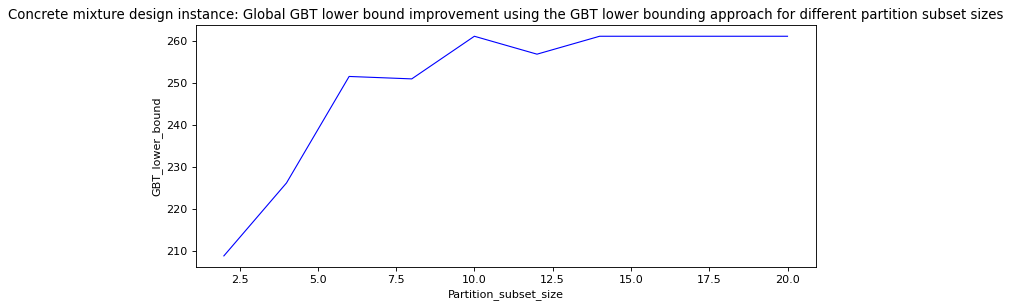

In [28]:
# plot figure
Partition_subset_size = list(lower_bounds.keys())       
GBT_lower_bound = list(lower_bounds.values())       
fig=plt.figure(figsize=(10,4))
plt.plot(Partition_subset_size,GBT_lower_bound,lw=1,ls="-",c="b")
plt.xlabel("Partition_subset_size")
plt.ylabel("GBT_lower_bound")
plt.title("Concrete mixture design instance: Global GBT lower bound improvement for different partition subset sizes")
plt.show()

The figure illustrates the global GBT lower bound improvement as the partition subset size increases. The curve is generally rising, but sometimes falling. This is because we only increase the partition subset size rather than use the partition refinement. The usage of partition refinement is as follows:

In [4]:
# Define the domain
lb={}
ub={}
for i in total_split_variable(trees):
    lb[i]=-50
    ub[i]=50

In [5]:
# Get the GBT lower bound with different tree partition subset size
S=Node(lb,ub,2,flag,trees)
lower_bounds={}
lower_bounds[0]=S.get_GBT_obj_val()
for i in range(0,4):
    P_=nonroot_partition_refinement(S.get_tree_partitionl())
    S.update_tree_partition(P_)
    lower_bounds[i]=S.get_GBT_obj_val()

We could get the dictionary of lower bounds again.

In [6]:
lower_bounds

{0: 226.14, 1: 250.94, 2: 261.1, 3: 261.1}

Then we plot a figure evaluating the GBT lower bounding.

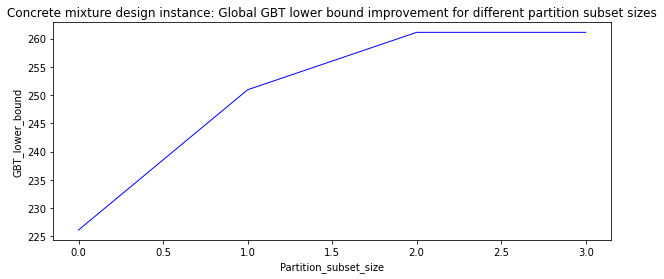

In [7]:
# plot figure
Partition_subset_size = list(lower_bounds.keys())       
GBT_lower_bound = list(lower_bounds.values())       
fig=plt.figure(figsize=(10,4))
plt.plot(Partition_subset_size,GBT_lower_bound,lw=1,ls="-",c="b")
plt.xlabel("Partition_subset_size")
plt.ylabel("GBT_lower_bound")
plt.title("Concrete mixture design instance: Global GBT lower bound improvement for different partition subset sizes")
plt.show()

We could find the GBT lower bound increasing. (This is the lemma 3)

## 2. Bounding method ——A classification problem

Firstly, we generate data.

In [9]:
x=np.linspace(0,10,100)
z=scipy.stats.norm.rvs(loc=0,size=100,scale=1)
y1=x**2
y=x**2+z
df=DataFrame({"x":x,"y":y,"class":z})
df["class"][df["class"]>=0]=1
df["class"][df["class"]<0]=0
xx=df[["x","y"]]
yy=df["class"]

In [10]:
df

,x,y,class
0,0.00000,1.965268,1.0
1,0.10101,-0.953233,0.0
2,0.20202,1.194085,1.0
3,0.30303,-0.201558,0.0
4,0.40404,0.140439,0.0
...,...,...,...
95,9.59596,91.207334,0.0
96,9.69697,94.475808,1.0
97,9.79798,97.718812,1.0
98,9.89899,96.096364,0.0


We use random forests classifier.

In [22]:
# random forests classifier (n_estimators=20)
flag=2 

#rf=get_rf_gb_(xx,yy,40,flag)

rf = RandomForestClassifier(n_estimators=40)
rf = rf.fit(xx,yy)
trees=get_input(rf,flag)

We define a function to get the GBT upperbound for a maximization problem.

In [23]:
def GBT_MIO_bound(tree_root_partition,flag,lb, ub):  
    bound=0
    for i in range(len(tree_root_partition)):
        bound=bound+GBT_upperbound_solver(tree_root_partition[i],flag,lb, ub)
    return bound

In [24]:
lb={}
ub={}
for i in total_split_variable(trees):
    lb[i]=-200
    ub[i]=200

In [25]:
upper_bounds_2={}
for i in range(2,42,2):
    upper_bounds_2[i]=GBT_MIO_bound(root_partition(i,trees),flag,lb, ub)

We could check the dictionary of upper bounds again.

In [26]:
upper_bounds_2

{2: 40.0,
 4: 40.0,
 6: 40.0,
 8: 40.0,
 10: 40.0,
 12: 40.0,
 14: 40.0,
 16: 40.0,
 18: 40.0,
 20: 40.0,
 22: 40.0,
 24: 40.0,
 26: 40.0,
 28: 40.0,
 30: 40.0,
 32: 40.00000000000013,
 34: 40.0,
 36: 40.0,
 38: 40.0,
 40: 40.0}

The reason of this phenomenon may be that the problem is a binary classification problem. It is easy to get the region that has a prediction of 1 for each tree. And the trees are independent but sometimes similar. So it is easy to get the maximum of the tree ensemble problem. 